# Plan Generator

## Gerenal Configuration

In [1]:
from topologicpy.Vertex import Vertex
from topologicpy.Face import Face
from topologicpy.Cell import Cell
from topologicpy.CellComplex import CellComplex
from topologicpy.Cluster import Cluster
from topologicpy.Topology import Topology
from topologicpy.Dictionary import Dictionary
from topologicpy.Color import Color
from topologicpy.Plotly import Plotly
from topologicpy.Graph import Graph
from topologicpy.Vector import Vector
from topologicpy.Helper import Helper

import random

In [2]:
def getSelectors(cell, keys, values):
    if not cell:
        return None
    # selectors = []
    s = Topology.InternalVertex(cell)
    d = Dictionary.ByKeysValues(keys, values)
    s = Topology.SetDictionary(s, d)
    # selectors.append(s)
    return s

def createPrism(dimension, location):
    w, l, h = dimension
    x, y, z = location
    prism = Cell.Prism(width=w, length=l, height=h, placement="lowerleft")
    prism = Topology.Translate(prism, x, y, z)
    return prism

def createWindows(is_linear=False):
    windows = []
    for face in CellComplex.ExternalFaces(house):
        if Face.FacingToward(face, [0, 0, -1]):
            continue
        if Face.FacingToward(face, [0, 0, 1]):
            continue
        if is_linear and Face.FacingToward(face, [-1, 0, 0]):
            continue
        if is_linear and Face.FacingToward(face, [1, 0, 0]):
            continue
        
        keys = ["label", "title", "is_entrance", "is_external", "is_wet_area", "width", "length", "height", "area", "volume"]
        values = [11, "Window", False, True, False, 1, 0, 1, 0, 0]
        window = Topology.Scale(face, x=0.5, y=0.5, z=0.5, origin=Topology.Centroid(face))
        
        d = Dictionary.ByKeysValues(keys, values)
        window = Topology.SetDictionary(window, d)
            
        windows.append(window)
    return windows

def createAperture(room1, room2, is_door=True):
    names = [room1, room2]
    names_sel = []
    for sel in selectors:
        if sel.GetDictionary().ValueAtKey('title').StringValue() == room1:
            names_sel.append(sel)
    for sel in selectors:
        if sel.GetDictionary().ValueAtKey('title').StringValue() == room2:
            names_sel.append(sel)
    names_sel

    if not names_sel:
        return

    sub1 = Topology.SelectSubTopology(house, names_sel[0], subTopologyType="cell")
    sub2 = Topology.SelectSubTopology(house, names_sel[1], subTopologyType="cell")
    # print(f'{room1} has {len(Cell.Faces(sub1))} faces   |   {room2} has {len(Cell.Faces(sub2))} faces')
    shared = Topology.SharedFaces(sub1, sub2)
    aperture = Topology.Copy(shared[0])
    aperture = shared[0]
    # print(aperture)
    
    keys = ["label", "title", "is_entrance", "is_external", "is_wet_area", "width", "length", "height", "area", "volume"]
    
    if is_door:
        width = 0.8
        height = 2.1
        area = 1.7        
    else:
        width = 3.0
        height = 3.0
        area = 9.0
    length = 0
    
    
    values = [12, "Door", False, False, False, width, length, height, area, 0]
    d = Dictionary.ByKeysValues(keys, values)
    aperture = Topology.SetDictionary(aperture, d)

    if not is_door:
        return aperture
    else:
        bottom_edge = Face.Edges(aperture)[0]
        for edge in Face.Edges(aperture):
            if Topology.Centroid(edge).Z() < Topology.Centroid(bottom_edge).Z():
                bottom_edge = edge
            
        return Topology.Scale(aperture, x=0.5, z=0.8, origin=Topology.Centroid(bottom_edge))

def getCellFloorArea(cell):
    bottom_face = Cell.Faces(cell)[0]
    for face in Topology.SubTopologies(cell, subTopologyType="face"):
        if Topology.Centroid(face).Z() < Topology.Centroid(bottom_face).Z():
            bottom_face = face
        return Face.Area(bottom_face)

In [3]:
labels = {
    "Stairs": 0,
    "Parking": 1,
    "Living": 2,
    "Dining": 3,
    "Kitchen": 4,
    "Office": 5,
    "Bedroom": 5,
    "WC": 6,
    "Service": 7,
    "Yard": 8,
    "Backyard": 8,
    "Patio": 8,
    "Garden": 8,
    "Terrace": 9,
    "Corridor": 10,
    "Window": 11,
    "Door": 12,
}

In [4]:
class Space():
    def __init__(self, name, is_entrance, is_external, is_wet_area, dimension, location):
        self.name = name
        self.is_entrance = is_entrance
        self.is_external = is_external
        self.is_wet_area = is_wet_area
        self.label = labels[name.split(" ")[0]]
        self.dim = dimension
        self.w = dimension[0]
        self.l = dimension[1]
        self.h = dimension[2]
        self.loc = location
        self.x = location[0]
        self.y = location[1]
        self.z = location[2]
        self.topo = createPrism(dimension, location)
        self.selector = getSelectors(
            self.topo,
            ["label", "title", "is_entrance", "is_external", "is_wet_area", "width", "length", "height", "area", "volume"], 
            [self.label, self.name, self.is_entrance, self.is_external, self.is_wet_area, self.w, self.l, self.h, getCellFloorArea(self.topo), Cell.Volume(self.topo)]
        )
        

### Defining Houses List

In [5]:
houses = []
configs = []

# House 1

In [6]:
def config_house_1():
    config = {
        "general_width": random.randint(60, 75) / 10,
        "general_height": random.randint(28, 32) / 10,
        "corridor_width": random.randint(9, 12) / 10,
        "has_patio": random.choice([True, False]),
        "has_bedroom1": random.choice([True, False]),
        "has_bedroom2": random.choice([True, False])
    }
    if not config['has_bedroom1']:
        config['has_bedroom2'] = True
        
    return config

In [7]:
def topo_house_1(config):
    general_width = config['general_width']
    general_height = config['general_height']
    corridor_width = config['corridor_width']
    
    has_patio = config['has_patio']
    has_bedroom1 = config['has_bedroom1']
    has_bedroom2 = config['has_bedroom2']


    ####################

    selectors = []
    cells = []
    keys = ["label", "title", "area", "volume"]
    
    parking = Space(
        "Parking",
        True,
        True,
        False,
        [general_width, 5.0, general_height],
        [0, 0, 0]
    )
    
    living = Space(
        "Living Room",
        False,
        False,
        False,
        [general_width, 4.5, general_height],
        [0,parking.l,0]
    )
    
    house = Topology.Boolean(parking.topo, living.topo, operation="merge")
    
    stairs = Space(
        "Stairs",
        False,
        False,
        False,
        [1.5, 5.0, general_height*2],
        [0,(living.y + living.l),0]
    )
    
    
    
    cells.extend([
        parking.topo,
        living.topo,
        stairs.topo,  
    ])
    
    selectors.extend([
        parking.selector,
        living.selector,
        stairs.selector,
    ])
    
    if has_patio:
        corridor1 = Space(
            "Corridor 1",
            False,
            False,
            False,
            [corridor_width, stairs.l, general_height],
            [stairs.w,(living.y + living.l),0]
        )
        
        wc1 = Space(
            "WC 1",
            False,
            False,
            True,
            [stairs.w, 1.2, general_height],
            [0, (stairs.y + stairs.l - 1.2),0]
        )
    
        wc2 = Space(
            "WC 2",
            False,
            False,
            True,
            [stairs.w, 1.2, general_height],
            [0, (wc1.y + wc1.l),0]
        )
    
        service = Space(
            "Service",
            False,
            False,
            True,
            [stairs.w, 3.0, general_height],
            [0, (wc2.y + wc2.l),0]
        )
    
        patio = Space(
            "Patio",
            False,
            True,
            False,
            [(general_width - stairs.w - corridor1.w), stairs.l, general_height*2],
            [(corridor1.x + corridor1.w), (living.y + living.l),0]
        )
        
        kitchen = Space(
            "Kitchen",
            False,
            False,
            True,
            [1.8, (wc2.l + service.l), general_height],
            [(general_width - 1.8), (patio.y + patio.l),0]
        )
    
        dining = Space(
            "Dining Room",
            False,
            False,
            False,
            [(general_width - wc1.w - kitchen.w), kitchen.l, general_height],
            [(wc1.x + wc1.w), (patio.y + patio.l),0]
        )
    
        backyard = Space(
            "Backyard",
            False,
            True,
            False,
            [general_width, 3.6, general_height],
            [0, (kitchen.y + kitchen.l),0]
        )    
    
        cells.extend([
            corridor1.topo,
            wc1.topo,
            wc2.topo,
            service.topo,
            patio.topo,
            kitchen.topo,
            dining.topo,
            backyard.topo,
        ])
    
        selectors.extend([
            corridor1.selector,
            wc1.selector,
            wc2.selector,
            service.selector,
            patio.selector,
            kitchen.selector,
            dining.selector,
            backyard.selector
        ])
    
    else:
        wc1 = Space(
            "WC 1",
            False,
            False,
            True,
            [stairs.w, 1.2, general_height],
            [0, (stairs.y + stairs.l - 1.2),0]
        )
    
        service = Space(
            "Service",
            False,
            False,
            True,
            [stairs.w, 3.0, general_height],
            [0, (wc1.y + wc1.l),0]
        )
        
        kitchen = Space(
            "Kitchen",
            False,
            False,
            True,
            [1.8, stairs.l, general_height],
            [(general_width - 1.8), (living.y + living.l),0]
        )
    
        dining = Space(
            "Dining Room",
            False,
            False,
            False,
            [(general_width - wc1.w - kitchen.w), kitchen.l, general_height],
            [(wc1.x + wc1.w), (living.y + living.l),0]
        )
    
        backyard = Space(
            "Backyard",
            False,
            False,
            True,
            [general_width, service.l, general_height],
            [0, (kitchen.y + kitchen.l),0]
        )    
    
        cells.extend([
            wc1.topo,
            service.topo,
            kitchen.topo,
            dining.topo,
            backyard.topo,
        ])
    
        selectors.extend([
            wc1.selector,
            service.selector,
            kitchen.selector,
            dining.selector,
            backyard.selector
        ])
    
    corridor2 = Space(
        "Corridor 2",
        False,
        False,
        False,
        [corridor_width, stairs.l, general_height],
        [stairs.w, (living.y + living.l), general_height]
    )
    
    cells.extend([corridor2.topo])
    selectors.extend([corridor2.selector])
    
    if has_bedroom1:
        wc3 = Space(
            "WC 3",
            False,
            False,
            True,
            [stairs.w, living.l, general_height],
            [0, (parking.y + parking.l), general_height]
        )
        
        bedroom1 = Space(
            "Bedroom 1",
            False,
            False,
            False,
            [(general_width - wc3.w), living.l, general_height],
            [wc3.w, (parking.y + parking.l), general_height]
        )
    
        cells.extend([
            wc3.topo,
            bedroom1.topo,
        ])
    
        selectors.extend([
            wc3.selector,
            bedroom1.selector,
        ])
        
    if has_bedroom2:
        if has_patio:
            wc4 = Space(
                "WC 4",
                False,
                False,
                True,
                [stairs.w, dining.l, general_height],
                [0, (stairs.y + stairs.l), general_height]
            )
            
            bedroom2 = Space(
                "Bedroom 2",
                False,
                False,
                False,
                [general_width - wc4.w, dining.l, general_height],
                [wc4.w, (patio.y + patio.l), general_height]
            )
    
            cells.extend([
                wc4.topo,
                bedroom2.topo,
            ])
        
            selectors.extend([
                wc4.selector,
                bedroom2.selector,
            ])
    
        else:
            bedroom2 = Space(
                "Bedroom 2",
                False,
                False,
                False,
                [(general_width - stairs.w - corridor2.w), dining.l, general_height],
                [(corridor2.x + corridor2.w), (living.y + living.l), general_height]
            )
    
            cells.extend([
                bedroom2.topo,
            ])
        
            selectors.extend([
                bedroom2.selector,
            ])
            
        
    
    for cell in cells:
        house = Topology.Boolean(house, cell, operation="merge")

    return cells, selectors, house
    

In [8]:
def aperture_house_1(config, selectors):
    
    
    has_patio = config['has_patio']
    has_bedroom1 = config['has_bedroom1']
    has_bedroom2 = config['has_bedroom2']

    apertures = []

    #####

    aperture = createWindows(is_linear=True)
    apertures.extend(aperture)
    
    aperture = createAperture("Parking", "Living Room", False)
    apertures.append(aperture)
    
    aperture = createAperture("Living Room", "Stairs", True)
    apertures.append(aperture)
    
    if has_patio:
        aperture = createAperture("Living Room", "Corridor 1", True)
        apertures.append(aperture)
        
        aperture = createAperture("Living Room", "Patio", False)
        apertures.append(aperture)
    
        aperture = createAperture("Patio", "Dining Room", False)
        apertures.append(aperture)
    
        aperture = createAperture("Patio", "Kitchen", False)
        apertures.append(aperture)
    
        aperture = createAperture("Dining Room", "Kitchen", True)
        apertures.append(aperture)
    
        aperture = createAperture("Corridor 1", "WC 1", False)
        apertures.append(aperture)
        
        aperture = createAperture("Corridor 1", "Dining Room", True)
        apertures.append(aperture)
    
        aperture = createAperture("WC 2", "Service", False)
        apertures.append(aperture)
    
        aperture = createAperture("Service", "Backyard", False)
        apertures.append(aperture)
    
        aperture = createAperture("Kitchen", "Backyard", False)
        apertures.append(aperture)
    
        aperture = createAperture("Dining Room", "Backyard", False)
        apertures.append(aperture)
    
    else:
        aperture = createAperture("Living Room", "Dining Room", False)
        apertures.append(aperture)
    
        aperture = createAperture("Living Room", "Kitchen", False)
        apertures.append(aperture)
    
        aperture = createAperture("Dining Room", "Kitchen", True)
        apertures.append(aperture)
    
        aperture = createAperture("Dining Room", "WC 1", False)
        apertures.append(aperture)
    
        aperture = createAperture("Service", "Backyard", False)
        apertures.append(aperture)
    
        aperture = createAperture("Kitchen", "Backyard", False)
        apertures.append(aperture)
    
        aperture = createAperture("Dining Room", "Backyard", False)
        apertures.append(aperture)
    
    aperture = createAperture("Stairs", "Corridor 2", False)
    apertures.append(aperture)
    
    if has_bedroom1:
        aperture = createAperture("Corridor 2", "Bedroom 1", False)
        apertures.append(aperture)
    
        aperture = createAperture("Bedroom 1", "WC 3", False)
        apertures.append(aperture)
    
    if has_bedroom2:
        aperture = createAperture("Corridor 2", "Bedroom 2", False)
        apertures.append(aperture)
        if has_patio:        
            aperture = createAperture("Bedroom 2", "WC 4", False)
            apertures.append(aperture)
    return apertures


In [9]:
def final_house_1(cells, selectors, apertures):
    selectors = Helper.Flatten(selectors)
    cells = Helper.Flatten(cells)
    house = CellComplex.ByCells(cells)
    house = Topology.TransferDictionariesBySelectors(house, selectors, tranCells=True)
    house = Topology.AddApertures(house, apertures, subTopologyType="face", exclusive=True)
    return house

In [10]:
for i in range(40):
    cells = []
    selectors = []
    apertures = []
    config = config_house_1()
    cells, selectors, house = topo_house_1(config)
    apertures = aperture_house_1(config, selectors)
    house = final_house_1(cells, selectors, apertures)
    houses.append(house)
    configs.append(config)  

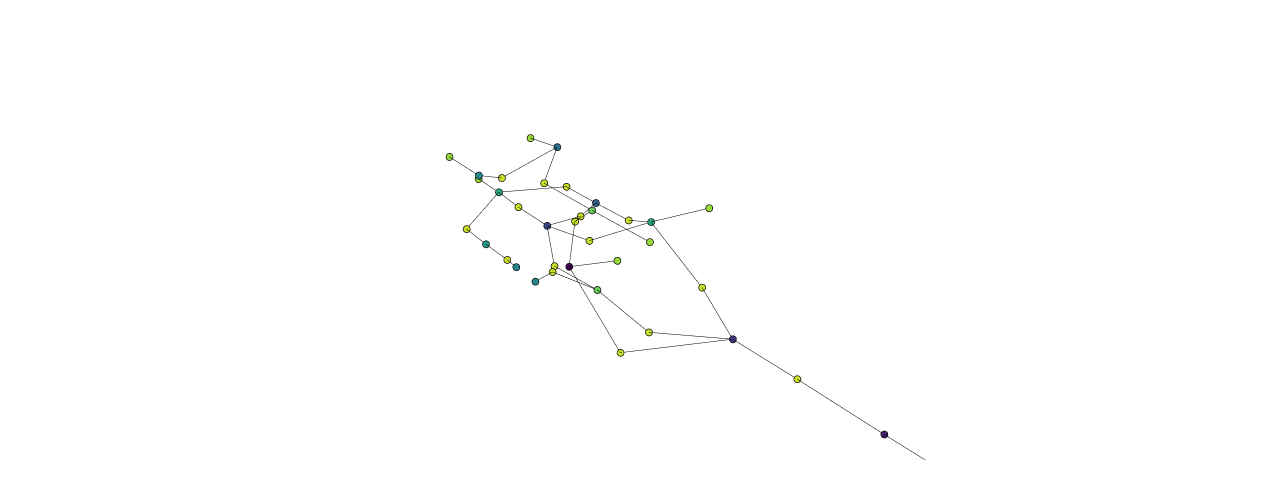

In [44]:
house = houses[0]

g = Graph.ByTopology(house, direct=False, viaSharedApertures=True, toExteriorApertures=True)
graph_data = Plotly.DataByGraph(g, vertexSize=4, vertexGroupKey="label", vertexLabelKey="title", vertexGroups=[0,1,2,3,4,5,6,7,8,9,10,11,12])
bldg_data = Plotly.DataByTopology(house, faceOpacity=0.1, edgeColor="darkgrey", vertexColor="lightgrey")
bldg_data = []
# graph_data = []
fig = Plotly.FigureByData(graph_data+bldg_data)
Plotly.Show(fig, renderer='jupyterlab')

# House 2

In [11]:
def config_house_2():
    config = {
        "general_width": random.randint(60, 75) / 10,
        "general_height": random.randint(28, 32) / 10,
        "corridor_width": random.randint(9, 12) / 10,
        "three_bedrooms": random.choice([True, False]),
    }
        
    return config

In [12]:
def topo_house_2(config):
    general_width = config['general_width']
    general_height = config['general_height']
    corridor_width = config['corridor_width']
    
    three_bedrooms = config['three_bedrooms']

    selectors = []
    cells = []
    apertures = []
    keys = ["label", "title", "area", "volume"]
    
    parking = Space(
        "Parking",
        True,
        True,
        False,
        [general_width, 5.0, general_height],
        [0, 0, 0]
    )
    
    living = Space(
        "Living Room",
        False,
        False,
        False,
        [general_width-corridor_width*2, 4.5, general_height],
        [corridor_width, parking.l, 0]
    )
    
    house = Topology.Boolean(parking.topo, living.topo, operation="merge")
    
    dining = Space(
        "Dining Room",
        False,
        False,
        False,
        [living.w, 3.5, general_height],
        [corridor_width, living.y + living.l, 0]
    )
    
    kitchen = Space(
        "Kitchen",
        False,
        False,
        True,
        [living.w, 1.5, general_height],
        [corridor_width, dining.y +  dining.l,0]
    )
    
    
    
    cells.extend([
        parking.topo,
        living.topo,
        dining.topo,
        kitchen.topo,
    ])
    
    selectors.extend([
        parking.selector,
        living.selector,
        dining.selector,
        kitchen.selector,
    ])
    
    
    if three_bedrooms:
        bedroom3 = Space(
            "Bedroom 3",
            False,
            False,
            False,
            [(living.w), 3.5, general_height],
            [corridor_width, (kitchen.y + kitchen.l), 0]
        )
    
        bedroom2 = Space(
            "Bedroom 2",
            False,
            False,
            False,
            [(living.w), 3.5, general_height],
            [corridor_width, (bedroom3.y + bedroom3.l), 0]
        )
    
        cells.extend([
            bedroom3.topo,
            bedroom2.topo,
        ])
    
        selectors.extend([
            bedroom3.selector,
            bedroom2.selector,
        ])
    
    else:
        bedroom2 = Space(
            "Bedroom 2",
            False,
            False,
            False,
            [living.w, 3.5, general_height],
            [corridor_width, kitchen.y + kitchen.l, 0]
        )
        
        cells.extend([
            bedroom2.topo,
        ])
    
        selectors.extend([
            bedroom2.selector,
        ])
    
    wc1 = Space(
        "WC 1",
        False,
        False,
        True,
        [living.w /2, 1.6, general_height],
        [corridor_width, bedroom2.y + bedroom2.l, 0]
    )
    
    wc2 = Space(
        "WC 2",
        False,
        False,
        True,
        [living.w /2, 1.6, general_height],
        [corridor_width + (living.w / 2), bedroom2.y + bedroom2.l, 0]
    )
    
    bedroom1 = Space(
        "Bedroom 1",
        False,
        False,
        False,
        [living.w, 3.5, general_height],
        [corridor_width, wc1.y + wc1.l, 0]
    )
    
    corridor1 = Space(
        "Corridor 1",
        False,
        False,
        False,
        [corridor_width, (bedroom1.y + bedroom1.l - parking.l), general_height],
        [0, living.y, 0]
    )
    
    garden = Space(
        "Garden",
        False,
        True,
        False,
        [corridor_width, (bedroom1.y + (bedroom1.l/2) - parking.l), general_height],
        [general_width - corridor_width, living.y, 0]
    )
    
    service = Space(
        "Service",
        False,
        False,
        True,
        [corridor_width, bedroom1.l/2, general_height],
        [general_width - corridor_width, bedroom1.y + bedroom1.l/2, 0]
    )
    
    backyard = Space(
        "Backyard",
        False,
        True,
        False,
        [general_width, 2.5, general_height],
        [0, bedroom1.y + bedroom1.l, 0]
    )
    
    cells.extend([
        wc1.topo,
        wc2.topo,
        bedroom1.topo,
        corridor1.topo,
        garden.topo,
        service.topo,
        backyard.topo,
    ])
    
    selectors.extend([
        wc1.selector,
        wc2.selector,
        bedroom1.selector,
        corridor1.selector,
        garden.selector,
        service.selector,
        backyard.selector,
    ])
    
    
    
    
    
    
    
    for cell in cells:    
        house = Topology.Boolean(house, cell, operation="merge")

    return cells, selectors, house

In [13]:
def aperture_house_2(config, selectors):
    three_bedrooms = config['three_bedrooms']

    aperture = createWindows(is_linear=True)
    apertures.extend(aperture)
    
    aperture = createAperture("Parking", "Living Room", False)
    apertures.append(aperture)
    
    aperture = createAperture("Living Room", "Dining Room", True)
    apertures.append(aperture)
    
    aperture = createAperture("Living Room", "Corridor 1", True)
    apertures.append(aperture)
    
    aperture = createAperture("Dining Room", "Kitchen", True)
    apertures.append(aperture)
    
    aperture = createAperture("Dining Room", "Corridor 1", True)
    apertures.append(aperture)
    
    aperture = createAperture("Kitchen", "Corridor 1", True)
    apertures.append(aperture)
    
    if three_bedrooms:
        aperture = createAperture("Bedroom 3", "Corridor 1", True)
        apertures.append(aperture)
    
    aperture = createAperture("Bedroom 2", "Corridor 1", True)
    apertures.append(aperture)
    
    aperture = createAperture("Bedroom 2", "WC 2", True)
    apertures.append(aperture)
    
    aperture = createAperture("Bedroom 1", "Corridor 1", True)
    apertures.append(aperture)
    
    aperture = createAperture("Bedroom 1", "WC 1", True)
    apertures.append(aperture)
    
    aperture = createAperture("Backyard", "Corridor 1", True)
    apertures.append(aperture)
    
    aperture = createAperture("Backyard", "Service", True)
    apertures.append(aperture)

    return apertures

In [14]:
def final_house_2(cells, selectors, apertures):
    selectors = Helper.Flatten(selectors)
    cells = Helper.Flatten(cells)
    house = CellComplex.ByCells(cells)
    house = Topology.TransferDictionariesBySelectors(house, selectors, tranCells=True)
    house = Topology.AddApertures(house, apertures, subTopologyType="face", exclusive=True)
    return house

In [15]:
for i in range(40):
    cells = []
    selectors = []
    apertures = []
    config = config_house_2()
    cells, selectors, house = topo_house_2(config)
    apertures = aperture_house_2(config, selectors)
    house = final_house_2(cells, selectors, apertures)
    houses.append(house)
    configs.append(config)


# House 3

In [16]:
def config_house_3():
    config = {
        "general_width": random.randint(60, 75) / 10,
        "general_height": random.randint(28, 32) / 10,
        "corridor_width": random.randint(9, 12) / 10,
        "three_bedrooms": random.choice([True, False]),
        
    }        
    return config

In [17]:
def topo_house_3(config):
    general_width = config['general_width']
    general_height = config['general_height']
    corridor_width = config['corridor_width']
    
    three_bedrooms = config['three_bedrooms']

    selectors = []
    cells = []
    apertures = []
    keys = ["label", "title", "area", "volume"]
    
    parking = Space(
        "Parking",
        True,
        True,
        False,
        [general_width - corridor_width, 5.0, general_height],
        [corridor_width, 0, 0]
    )
    
    stairs = Space(
        "Stairs",
        False,
        False,
        False,
        [2.0, 2.0, 2 * general_height ],
        [corridor_width, parking.l, 0]
    )
    
    terrace1 = Space(
        "Terrace 1",
        True,
        True,
        False,
        [corridor_width, (parking.l + stairs.l), general_height],
        [0, 0, 0]
    )
    
    wc1 = Space(
        "WC 1",
        False,
        False,
        True,
        [1.4, 2.0, general_height ],
        [(stairs.x + stairs.w), parking.l, 0]
    )
    
    service = Space(
        "Service",
        False,
        False,
        True,
        [(parking.w - stairs.w - wc1.w), 2.0, general_height ],
        [(wc1.x + wc1.w), parking.l, 0]
    )
    
    dining = Space(
        "Dining Room",
        False,
        False,
        False,
        [(stairs.w + corridor_width), 4.5, general_height],
        [0, (stairs.w + stairs.y), 0]
    )
    
    living = Space(
        "Living Room",
        False,
        False,
        False,
        [dining.w, 3.5, general_height],
        [0, dining.y + dining.l, 0]
    )
    
    terrace2 = Space(
        "Terrace 2",
        False,
        True,
        False,
        [living.w, 1.5, general_height],
        [0, living.y + living.l, 0]
    )
    
    kitchen = Space(
        "Kitchen",
        False,
        False,
        True,
        [(wc1.w + service.w), dining.l, general_height],
        [wc1.x, (stairs.w + stairs.y), 0]
    )
    
    bedroom1 = Space(
        "Bedroom 1",
        False,
        False,
        False,
        [kitchen.w, living.l, general_height],
        [wc1.x, kitchen.y + kitchen.l, 0]
    )
    
    wc2 = Space(
        "WC 2",
        False,
        False,
        True,
        [bedroom1.w, terrace2.l, general_height],
        [wc1.x, bedroom1.y + bedroom1.l, 0]
    )
    
    # SECOND FLOOR
    
    corridor1 = Space(
        "Corridor 1",
        False,
        False,
        False,
        [corridor_width, stairs.l, general_height ],
        [0, stairs.y, general_height]
    )
    
    living2 = Space(
        "Living Room 2",
        False,
        False,
        False,
        [(dining.w + kitchen.w), dining.l, general_height],
        [0, dining.y, general_height]
    )
    
    office = Space(
        "Office",
        False,
        False,
        False,
        [dining.w, 3.5, general_height],
        [0, dining.y + dining.l, general_height]
    )
    
    terrace3 = Space(
        "Terrace 3",
        False,
        True,
        False,
        [living.w, 1.5, general_height],
        [0, living.y + living.l, general_height]
    )
    
    bedroom2 = Space(
        "Bedroom 2",
        False,
        False,
        False,
        [kitchen.w, living.l, general_height],
        [wc1.x, kitchen.y + kitchen.l, general_height]
    )
    
    wc3 = Space(
        "WC 3",
        False,
        False,
        True,
        [bedroom1.w, terrace2.l, general_height],
        [wc1.x, bedroom1.y + bedroom1.l, general_height]
    )
    
    
    house = Topology.Boolean(parking.topo, stairs.topo, operation="merge")
    
    cells.extend([
        parking.topo,
        terrace1.topo,
        stairs.topo,
        wc1.topo,
        service.topo,
        dining.topo,
        living.topo,    
        terrace2.topo,
        kitchen.topo,
        bedroom1.topo,    
        wc2.topo,
        living2.topo,
        office.topo,
        terrace3.topo,
        bedroom2.topo,
        wc3.topo,
        corridor1.topo,
    ])
    selectors.extend([
        parking.selector,
        terrace1.selector,
        stairs.selector,
        wc1.selector,
        service.selector,
        dining.selector,
        living.selector,
        terrace2.selector,
        kitchen.selector,
        bedroom1.selector,    
        wc2.selector,
        living2.selector,
        office.selector,
        terrace3.selector,
        bedroom2.selector,
        wc3.selector,
        corridor1.selector,
    ])
    
    
    if three_bedrooms:
    
        
        bedroom3 = Space(
            "Bedroom 3",
            False,
            False,
            False,
            [general_width, 5.0, general_height],
            [0, 0, general_height]
        )
    
        wc4 = Space(
            "WC 4",
            False,
            False,
            True,
            [(wc1.w + service.w), stairs.l, general_height ],
            [(stairs.x + stairs.w), parking.l, general_height]
        )
    
        cells.extend([
            bedroom3.topo,
            wc4.topo,
        ])
    
        selectors.extend([
            bedroom3.selector,
            wc4.selector,
        ])   
    
    
    
    for cell in cells:    
        house = Topology.Boolean(house, cell, operation="merge")
    
    return cells, selectors, house

In [18]:
def aperture_house_3(config, selectors):
    three_bedrooms = config['three_bedrooms']

    aperture = createWindows(is_linear=False)
    apertures.extend(aperture)

    aperture = createAperture("Parking", "Terrace 1", False)
    apertures.append(aperture)
    
    aperture = createAperture("Terrace 1", "Stairs",  True)
    apertures.append(aperture)
    
    aperture = createAperture("Terrace 1", "Dining Room",  True)
    apertures.append(aperture)
    
    aperture = createAperture("Dining Room", "Kitchen", True)
    apertures.append(aperture)
    
    aperture = createAperture("Kitchen", "Service", False)
    apertures.append(aperture)
    
    aperture = createAperture("Service", "WC 1",  False)
    apertures.append(aperture)
    
    aperture = createAperture("Dining Room", "Living Room", True)
    apertures.append(aperture)
    
    aperture = createAperture("Living Room", "Terrace 2", False)
    apertures.append(aperture)
    
    aperture = createAperture("Living Room", "Bedroom 1", False)
    apertures.append(aperture)
    
    aperture = createAperture("Bedroom 1", "WC 2", False)
    apertures.append(aperture)
    
    aperture = createAperture("Corridor 1", "Stairs", True)
    apertures.append(aperture)
    
    aperture = createAperture("Corridor 1", "Living Room 2", True)
    apertures.append(aperture)
    
    aperture = createAperture("Living Room 2", "Office", False)
    apertures.append(aperture)
    
    aperture = createAperture("Living Room 2", "Bedroom 2", False)
    apertures.append(aperture)
    
    aperture = createAperture("Bedroom 2", "WC 3", False)
    apertures.append(aperture)
    
    aperture = createAperture("Office", "Terrace 3", False)
    apertures.append(aperture)
    
    
    
    if three_bedrooms:
        aperture = createAperture("Bedroom 3", "Corridor 1", True)
        apertures.append(aperture)
    
        aperture = createAperture("Bedroom 3", "WC 4", True)
        apertures.append(aperture)

    return apertures

In [19]:
def final_house_3(cells, selectors, apertures):
    selectors = Helper.Flatten(selectors)
    cells = Helper.Flatten(cells)
    house = CellComplex.ByCells(cells)
    house = Topology.TransferDictionariesBySelectors(house, selectors, tranCells=True)
    house = Topology.AddApertures(house, apertures, subTopologyType="face", exclusive=True)
    return house

In [20]:
for i in range(40):
    cells = []
    selectors = []
    apertures = []
    config = config_house_3()
    cells, selectors, house = topo_house_3(config)
    apertures = aperture_house_3(config, selectors)
    house = final_house_3(cells, selectors, apertures)
    houses.append(house)
    configs.append(config)


# House 4

In [21]:
def config_house_4():
    config = {
        "general_height": random.randint(28, 32) / 10,
        "wc_length": random.randint(12, 15) / 10,
        "corridor_width": random.randint(9 ,12) / 10,
        "stairs_length": 1.4,
        "x1": 0,
        "x2": random.randint(60, 80) / 10,
        "x3": random.randint(40, 50) / 10,
        "y1": 0,
        "y2": random.randint(40, 50) / 10,
        "y3": random.randint(40, 50) / 10,
        "y4": random.randint(30, 40) / 10,
        "floor1": 0,
        "floor2": 0,
        "floor3": 0,   
    }
    config['floor2'] = config["general_height"] / 2
    config['floor3'] = config["general_height"]    
        
    return config

In [22]:
def topo_house_4(config):
    general_height = config['general_height']
    wc_length = config['wc_length']
    corridor_width = config['corridor_width']
    stairs_length = config['stairs_length']
    x1 = config['x1']
    x2 = config['x2']
    x3 = config['x3']
    y1 = config['y1']
    y2 = config['y2']
    y3 = config['y3']
    y4 = config['y4']
    floor1 = config['floor1']
    floor2 = config['floor2']
    floor3 = config['floor3']

    #######
    selectors = []
    cells = []
    apertures = []
    keys = ["label", "title", "area", "volume"]
    
    terrace = Space(
        "Terrace",
        True,
        True,
        False,
        [x3, y2, general_height],
        [x2, y1, floor1]
    )
    
    office = Space(
        "Office",
        False,
        False,
        False,
        [x3, y3, general_height],
        [x2 + corridor_width, y2, floor1] 
    )
    
    stairs1 = Space(
        "Stairs 1",
        False,
        False,
        False,
        [corridor_width, stairs_length, general_height + floor2], # TODO CHECK HEIGHT
        [x2, y2, floor1]
    )
    
    corridor1 = Space(
        "Corridor 1",
        False,
        False,
        False,
        [corridor_width, y3 - stairs1.l + wc_length, general_height],
        [x2, y2 + stairs1.l, floor2]
    )
    
    living = Space(
        "Living Room",
        False,
        False,
        False,
        [x2, y3, general_height],
        [x1, y2, floor2]
    )
    
    dining = Space(
        "Dining Room",
        False,
        False,
        False,
        [3, y4, general_height],
        [x1 + 0.5, y2+y3, floor2]
    )
    
    wc1 = Space(
        "WC 1",
        False,
        False,
        True,
        [x2 - dining.w - 0.5, wc_length, general_height ],
        [dining.x + dining.w, y2+y3, floor2]
    )
    
    kitchen = Space(
        "Kitchen",
        False,
        False,
        True,
        [x2 - dining.w - 0.5 + corridor_width, 3.0, general_height ],
        [dining.x + dining.w, y2+y3+wc1.l, floor2]
    )
    
    bedroom1 = Space(
        "Bedroom 1",
        False,
        False,
        False,
        [x3, y3, general_height],
        [x2 + corridor_width, y2, floor3] 
    )
    
    stairs2 = Space(
        "Stairs 2",
        False,
        False,
        False,
        [stairs_length, wc1.l, general_height + floor2], 
        [x2 + corridor_width, y2+y3, floor2] 
    )
    
    service = Space(
        "Service",
        False,
        False,
        False,
        [corridor1.w, kitchen.l, general_height],
        [corridor1.x + corridor_width, kitchen.y, floor2]
    )
    
    house = Topology.Boolean(terrace.topo, office.topo, operation="merge")
    
    cells.extend([
        terrace.topo,
        office.topo,
        stairs1.topo,
        corridor1.topo,
        living.topo,
        dining.topo,   
        wc1.topo,
        kitchen.topo,
        bedroom1.topo,  
        stairs2.topo,
        service.topo,
    ])
    
    selectors.extend([
        terrace.selector,
        office.selector,
        stairs1.selector,
        corridor1.selector,
        living.selector,
        dining.selector,
        wc1.selector,
        kitchen.selector,
        bedroom1.selector,    
        stairs2.selector,
        service.selector,
    ])
    
    
    for cell in cells: 
        house = Topology.Boolean(house, cell, operation="merge")


    return cells, selectors, house
    


In [23]:
def aperture_house_4(config, selectors):
    aperture = createWindows(is_linear=False)
    apertures.extend(aperture)
    
    aperture = createAperture("Terrace", "Office", False)
    apertures.append(aperture)
    
    aperture = createAperture("Terrace", "Stairs 1", True)
    apertures.append(aperture)
    
    aperture = createAperture("Stairs 1", "Corridor 1", True)
    apertures.append(aperture)
    
    aperture = createAperture("Corridor 1", "Living Room", True)
    apertures.append(aperture)
    
    aperture = createAperture("Corridor 1", "WC 1", False)
    apertures.append(aperture)
    
    aperture = createAperture("Corridor 1", "Kitchen", True)
    apertures.append(aperture)
    
    aperture = createAperture("Living Room", "Dining Room", True)
    apertures.append(aperture)
    
    aperture = createAperture("Dining Room", "Kitchen", True)
    apertures.append(aperture)
    
    aperture = createAperture("Kitchen", "Service",  False)
    apertures.append(aperture)
    
    aperture = createAperture("Corridor 1", "Stairs 2", True)
    apertures.append(aperture)
    
    aperture = createAperture("Stairs 2", "Bedroom 1",  True)
    apertures.append(aperture)

    return apertures

In [24]:
def final_house_4(cells, selectors, apertures):
    selectors = Helper.Flatten(selectors)
    cells = Helper.Flatten(cells)
    house = CellComplex.ByCells(cells)
    house = Topology.TransferDictionariesBySelectors(house, selectors, tranCells=True)
    house = Topology.AddApertures(house, apertures, subTopologyType="face", exclusive=True)
    return house

In [25]:
for i in range(40):
    cells = []
    selectors = []
    apertures = []
    config = config_house_4()
    cells, selectors, house = topo_house_4(config)
    apertures = aperture_house_4(config, selectors)
    house = final_house_4(cells, selectors, apertures)
    houses.append(house)
    configs.append(config)


# House 5

In [26]:
def config_house_5():
    config = {
        "general_width": random.randint(30, 45) / 10,
        "general_height": random.randint(28, 32) / 10,
        "terrace_width": random.randint(15, 20) / 10,
        "corridor_width": random.randint(9, 12) / 10,
        "three_bedrooms": random.choice([True, False]),
    }        
    return config

In [27]:
def topo_house_5(config):
    general_width = config['general_width']
    general_height = config['general_height']
    terrace_width = config['terrace_width']
    corridor_width = config['corridor_width']
    three_bedrooms = config['three_bedrooms']

    selectors = []
    cells = []
    apertures = []
    keys = ["label", "title", "area", "volume"]
    
    living = Space(
        "Living Room",
        True,
        False,
        False,
        [general_width, 5, general_height],
        [0, 0, 0]
    )
    
    dining = Space(
        "Dining Room",
        False,
        False,
        False,
        [general_width, 5, general_height],
        [0, living.l, 0] 
    )
    
    kitchen = Space(
        "Kitchen",
        True,
        False,
        True,
        [general_width, 6, general_height],
        [0, living.l + dining.l, 0] 
    )
    
    service = Space(
        "Service",
        False,
        False,
        True,
        [general_width, 2.5, general_height],
        [0, living.l + dining.l + kitchen.l, 0] 
    )
    
    
    
    bedroom1_position = [dining.w, living.l + dining.l - general_width, 0]
    corridor_length = 0
    if three_bedrooms:
        bedroom3 = Space(
            "Bedroom 3",
            False,
            False,
            False,
            [3.5, general_width, general_height],
            [dining.w, living.l + dining.l - general_width, 0]
        )
        
        bedroom1_position = [bedroom3.x + bedroom3.w, living.l + dining.l - general_width, 0]
        corridor_length += bedroom3.w
        
        cells.extend([
            bedroom3.topo,
        ])
        selectors.extend([
            bedroom3.selector,
        ])
        
        
    
    bedroom1 = Space(
        "Bedroom 1",
        False,
        False,
        False,
        [3.5, general_width, general_height],
        bedroom1_position
    )
    
    bedroom2 = Space(
        "Bedroom 2",
        False,
        False,
        False,
        [3.5, general_width + corridor_width, general_height],
        [bedroom1.x + bedroom1.w, bedroom1.y, 0]
    )
    
    corridor_length += bedroom1.w
    
    corridor = Space(
        "Corridor",
        False,
        False,
        False,
        [corridor_length, corridor_width, general_height], # Mudar o primeiro valor
        [dining.w, living.l + dining.l, 0]
    )
    
    wc1 = Space(
        "WC 1",
        False,
        False,
        True,
        [2.4, 2.4, general_height],
        [bedroom2.x - 2.4, corridor.y + corridor_width, 0] # Make 2.4 parametric
    )
    
    wc2 = Space(
        "WC 2",
        False,
        False,
        True,
        [2.4, 2.4, general_height],
        [bedroom2.x, corridor.y + corridor_width, 0] # Make 2.4 parametric
    )
    
    
    terrace1 = Space(
        "Terrace 1",
        True,
        True,
        False,
        [terrace_width, kitchen.y - bedroom1.l, general_height],
        [general_width, 0, 0]
    )
    
    terrace2 = Space(
        "Terrace 2",
        True,
        True,
        False,
        [bedroom2.x + bedroom2.w - general_width, terrace_width, general_height],
        [general_width + terrace_width, bedroom1.y - terrace_width, 0]
    )
    
    
    house = Topology.Boolean(living.topo, dining.topo, operation="merge")
    
    cells.extend([
        living.topo,
        dining.topo,
        kitchen.topo,
        service.topo,
        corridor.topo,
        bedroom1.topo,
        bedroom2.topo,
        wc1.topo,
        wc2.topo,
        terrace1.topo,
        terrace2.topo,
    ])
    selectors.extend([
        living.selector,
        dining.selector,
        kitchen.selector,
        service.selector,
        corridor.selector,
        bedroom1.selector,
        bedroom2.selector,
        wc1.selector,
        wc2.selector,
        terrace1.selector,
        terrace2.selector,
    ])
    
    
    for cell in cells:    
        house = Topology.Boolean(house, cell, operation="merge")

    return cells, selectors, house

In [28]:
def aperture_house_5(config, selectors):
    three_bedrooms = config['three_bedrooms']

    aperture = createWindows(is_linear=False)
    apertures.extend(aperture)

    aperture = createAperture("Living Room", "Dining Room", True)
    apertures.append(aperture)
    
    aperture = createAperture("Living Room", "Terrace 1", False)
    apertures.append(aperture)
    
    aperture = createAperture("Dining Room", "Terrace 1", False)
    apertures.append(aperture)
    
    aperture = createAperture("Dining Room", "Kitchen", True)
    apertures.append(aperture)
    
    aperture = createAperture("Kitchen", "Service", False)
    apertures.append(aperture)
    
    aperture = createAperture("Kitchen", "Corridor", True)
    apertures.append(aperture)
    
    aperture = createAperture("Corridor", "Bedroom 1", False)
    apertures.append(aperture)
    
    aperture = createAperture("Corridor", "WC 1", False)
    apertures.append(aperture)
    
    aperture = createAperture("Corridor", "Bedroom 2", False)
    apertures.append(aperture)
    
    aperture = createAperture("Bedroom 2", "WC 2", False)
    apertures.append(aperture)
    
    aperture = createAperture("Bedroom 1", "Terrace 2", False)
    apertures.append(aperture)
    
    aperture = createAperture("Bedroom 2", "Terrace 2", False)
    apertures.append(aperture)
    
    if three_bedrooms:
        aperture = createAperture("Corridor", "Bedroom 3", False)
        apertures.append(aperture)
    
        aperture = createAperture("Bedroom 3", "Terrace 2", False)
        apertures.append(aperture)
    
    aperture = createAperture("Terrace 1", "Terrace 2", True)
    apertures.append(aperture)
    




    return apertures

In [29]:
def final_house_5(cells, selectors, apertures):
    selectors = Helper.Flatten(selectors)
    cells = Helper.Flatten(cells)
    house = CellComplex.ByCells(cells)
    house = Topology.TransferDictionariesBySelectors(house, selectors, tranCells=True)
    house = Topology.AddApertures(house, apertures, subTopologyType="face", exclusive=True)
    return house

In [30]:
for i in range(40):
    cells = []
    selectors = []
    apertures = []
    config = config_house_5()
    cells, selectors, house = topo_house_5(config)
    apertures = aperture_house_5(config, selectors)
    house = final_house_5(cells, selectors, apertures)
    houses.append(house)
    configs.append(config)


# Joining all houses and exporting

In [31]:
graphs = []
for house in houses:
    g = Graph.ByTopology(house, direct=False, viaSharedApertures=True, toExteriorApertures=True)
    graphs.append(g)
    
    

In [32]:
# for g in graphs:
#     print(s.GetDictionary().ValueAtKey("title").StringValue())

In [33]:
for i, g in enumerate(graphs):
    overwrite = False
    if i == 0:
        overwrite=True
    Graph.ExportToCSV(g, "./data3", 0, overwrite=overwrite, nodeFeaturesKeys=["is_entrance", "is_external", "is_wet_area", "width", "length", "height", "area", "volume"])